# Task 1: Import Libraries

In [2]:
from PIL import Image
from datasets import load_dataset

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.transforms import (RandomVerticalFlip, CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor)
from transformers import ViTImageProcessor,ViTForImageClassification,TrainingArguments, Trainer

from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import torch

# Task 2: Load the Dataset

In [3]:
train_validation_ds = load_dataset("/usercode/mnist_dataset/", split='train[:500]')
test_ds = load_dataset("/usercode/mnist_dataset/", split='test[:10]')

train_validation_splits = train_validation_ds.train_test_split(test_size=0.1)
train_ds, validation_ds = train_validation_splits['train'], train_validation_splits['test']

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Task 3: Visualize the Dataset

In [4]:
train_ds[0]["image"]

<BarContainer object of 10 artists>

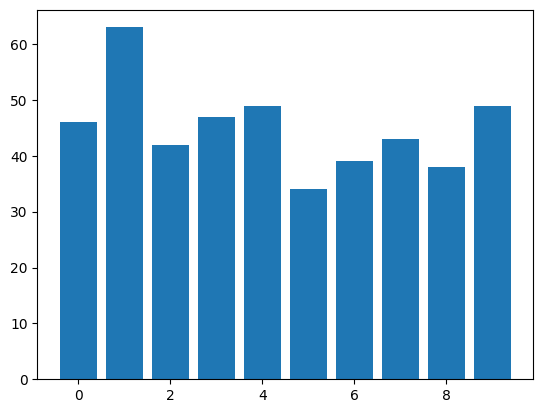

In [5]:
train_labels = Counter([point['label'] for point in train_ds])
plt.clf()
plt.bar(train_labels.keys(), train_labels.values())

# Task 4: Create a Mapping of Class Names to Index

In [6]:
def get_label_id_maps(dataset):
    label_names = dataset.features.get('label').names
    id2label = {id: label for id, label in enumerate(label_names)}
    label2id = {label: id for id, label in id2label.items()}
    return id2label, label2id

id2label, label2id = get_label_id_maps(train_ds)

num_labels = len(id2label)

# Task 5: Load the Preprocessor for the Dataset

In [7]:
PRETRAINED_MODEL_NAME = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(PRETRAINED_MODEL_NAME)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

# Task 6: Define Data Augmentations

In [8]:
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"], processor.size["width"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
    [
        RandomHorizontalFlip(p=0.2),
        RandomVerticalFlip(p=0.1),
        RandomResizedCrop(size),
        ToTensor(),
        normalize,
    ]
)

_validation_transforms = Compose(
    [
        Resize(size),
        ToTensor(),
        normalize,
    ]
)

# Task 7:  Implement Data Transformation

In [9]:
def train_transforms(batch):
    rgb_images = [image.convert("RGB") for image in batch['image']]
    batch['pixel_values'] = [_train_transforms(image) for image in rgb_images]
    return batch

def validation_transforms(batch):
    rgb_images = [image.convert("RGB") for image in batch['image']]
    batch['pixel_values'] = [_validation_transforms(image) for image in rgb_images]
    return batch

train_ds.set_transform(train_transforms)
validation_ds.set_transform(validation_transforms)
test_ds.set_transform(validation_transforms)

# Task 8: Collate the Function for DataLoader

In [10]:
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    labels = torch.tensor([example["label"] for example in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Task 9: Create a Model

In [11]:
model = ViTForImageClassification.from_pretrained(
    PRETRAINED_MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Task 10: Define a Metric for the Model

In [12]:
def evaluate(pred_labels):
    predictions, labels = pred_labels.predictions, pred_labels.label_ids
    predictions = np.argmax(predictions, axis=1)
    return {"f1": f1_score(predictions, labels, average='micro')}

# Task 11: Set Up Trainer Arguments

In [13]:
METRIC_NAME = "f1"

args = TrainingArguments(
    output_dir = "mnist-model-output",
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    per_device_train_batch_size = 20,
    per_device_eval_batch_size = 16,
    logging_steps = 100,
    learning_rate = 1e-5,
    num_train_epochs = 1,
    weight_decay = 0.01,
    save_total_limit = 2,
    load_best_model_at_end = True,
    metric_for_best_model = METRIC_NAME,
    logging_dir = 'logs',
    remove_unused_columns = False,
)

# Task 12: Create a Trainer Object

In [14]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train_ds,
    eval_dataset = validation_ds,
    data_collator = collate_fn,
    compute_metrics = evaluate,
    tokenizer = processor,
)

# Task 13: Evaluate the Model Before Training

In [15]:
outputs_before_training = trainer.predict(validation_ds)
print(outputs_before_training.metrics)

{'test_loss': 2.3824379444122314, 'test_f1': 0.02, 'test_runtime': 31.5135, 'test_samples_per_second': 1.587, 'test_steps_per_second': 0.127}


# Task 14: Train the Model

In [16]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,2.323539,0.100000


# Task 15: Visualize the Performance in TensorBoard

In [17]:
%load_ext tensorboard
%tensorboard --logdir=/logs --host 0.0.0.0 --port 3000

# Task 16: Evaluate the Model

In [18]:
trained_model = ViTForImageClassification.from_pretrained(
    "./usercode/trained_model/"
)

trainer.model = trained_model
outputs_after_training = trainer.predict(validation_ds)
print(outputs_after_training.metrics)

{'test_loss': 0.551565408706665, 'test_f1': 1.0, 'test_runtime': 31.287, 'test_samples_per_second': 1.598, 'test_steps_per_second': 0.128}


# Task 17: Set Up the Confusion Matrix

Text(20.72222222222222, 0.5, 'True Labels')

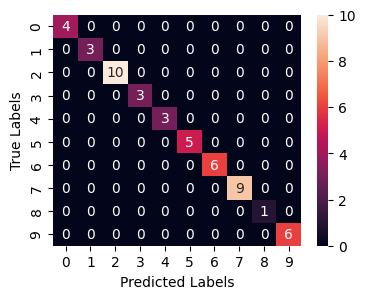

In [19]:
x_true = outputs_after_training.label_ids
y_pred = outputs_after_training.predictions.argmax(axis=1)

model_confusion_matrix = confusion_matrix(x_true, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(model_confusion_matrix, annot = True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Task 18: Save the Model and Metrics

In [20]:
trainer.save_model()
trainer.save_metrics("evaluation", outputs_after_training.metrics)
trainer.save_state()

# Task 19: Set Up an Inference for the Model

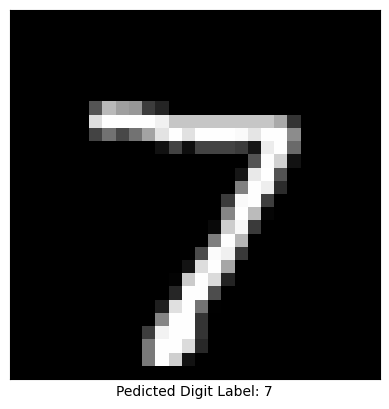

In [21]:
def show_results(test_image, prediction):
    plt.figure()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(test_image)
    plt.xlabel(f'Pedicted Digit Label: {prediction}')
    plt.show()

test_image = test_ds[0]["image"].convert("RGB")
inputs = processor(images=test_image, return_tensors="pt")
pixel_values = inputs.pixel_values
test_logits = trained_model(pixel_values).logits
prediction_id = test_logits.argmax(-1).item()
prediction_label = id2label[prediction_id]
show_results(test_image, prediction_label)